# Channel cross-section evolution


## Python setup

In [1]:
import bedrock_river as br, sympy as sy, numpy as np, matplotlib.pyplot as plt
from sympy import Eq
from dill.source import getsource
sy.init_printing(pretty_print=True,wrap_line=True)
from symbols import *

In [2]:
cm = br.channel.new_model()
cm.get_params()


Initializing open channel flow hydraulics...done


## Recipe

1. Fix base width $w$, slope $\beta_0$, sinuosity $\chi=0$
2. Fix wall angle $\theta=\pi/2$ thus imposing simple initial rectangular cross-section (ignoring beveled corners)

Loop:
3. Compute flow speed $u$ and flow depth $d$
4. Compute bedload flux $q_b$
5. Compute suspended load flux profile fractions at (i) wall-base corner $q_c$ (ii) remainder above corner $q_w$
6. Optionally compute wall & corner weathering rates to modulate their erodibility
7. Compute base wear rate $\xi_b$, corner wear rate $\xi_c$ and wall wear rate $\xi_w$
8. Compute base-corner vector $\vec{\xi}_{bc}$, base-corner vector dip (from vertical) $\theta$
9. Convert into rate of change of base channel width $\dot{w}$;  secondarily compute base elevation $\dot{h}$
10. Compute wall base-corner-driven motion vector $\vec{\xi}_{wc}$ and wall rotation rate $\dot{\theta}$
11. Time step by $\Delta{t}$ the ODE system $(\dot{w}, \dot{\theta})$ of rates of change of channel base width and wall dip; secondarily evolve base elevation $\dot{h}$ 
12. Repeat

## Open channel flow

### Cross-sectional area and wetted perimeter $p$

Flow cross-sectional area $A$:

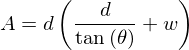

In [3]:
cm.A_eqn_geom()

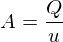

In [4]:
cm.A_eqn_dyn()

Wetted perimeter $p$:

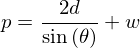

In [5]:
cm.p_eqn()

    def R_eqn(self):
        return Eq(R, self.A_eqn_dyn().rhs/self.p_eqn().rhs).simplify()



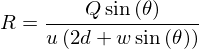

In [6]:
print(getsource(cm.R_eqn))
cm.R_eqn()

### Boundary friction

Dimensionless $C_Z$ vs dimensioned $C$ Chézy roughness (resistance) coefficients 

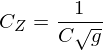

In [7]:
Eq(C,C.subs(cm.get_params()))
Cz_eqn = Eq(Cz, 1/(sy.sqrt(g)*C))
Cz_eqn
Cz_eqn.subs(cm.get_params())

Dimensionless friction factor $f=1/C_Z^2$

In [8]:
cm.set_friction_model('chezy')
cm.friction_eqn()
_.subs(cm.get_params())

Friction factor $f$ and Manning's $n$:

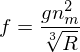

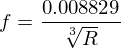

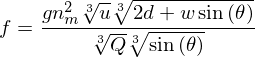

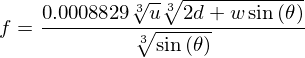

In [9]:
cm.set_friction_model('manning')
cm.friction_eqn_manning_raw()
_.subs(cm.get_params())
cm.friction_eqn()
_.subs(cm.get_params())

### Boundary shear stress $\tau$ from force (momentum) balance

Mean boundary shear stress $\tau$, averaged along wetted perimeter $p$:

    def tau_eqn_raw(self):
        return Eq(tau,(rho*g*A*sy.sin(beta)/p).subs(A,self.A_eqn_dyn().rhs))



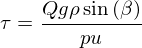

In [10]:
print(getsource(cm.tau_eqn_raw))
cm.tau_eqn_raw()

    def tau_eqn_geom(self):
        return self.tau_eqn_raw().subs(p,self.p_eqn().rhs).simplify()



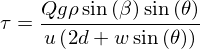

In [11]:
print(getsource(cm.tau_eqn_geom))
cm.tau_eqn_geom()

### Boundary shear stress $\tau$ from friction

Mean shear stress at a rough boundary:

In [12]:
cm.tau_eqn_friction()
# cm.tau_eqn_manning_friction()

Combining for each roughness model, we have mean boundary shear stress for Chézy versus Manning:

In [13]:
cm.set_friction_model('chezy')
cm.tau_eqn_friction().subs(f,cm.friction_eqn().rhs)

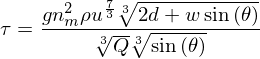

In [14]:
cm.set_friction_model('manning')
cm.tau_eqn_friction().subs(f,cm.friction_eqn_manning().rhs)

### Shear velocity $u^*$

Shear or friction "velocity" $u^*$:

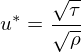

In [15]:
cm.u_star_eqn_raw()

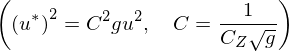

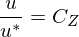

In [16]:
tmp = sy.Eq(u_star**2,(cm.u_star_eqn_raw().rhs**2).subs(tau,
    cm.tau_eqn_friction().subs(f,cm.friction_eqn_chezy().rhs).rhs))
tmp, Eq(C,1/(sy.sqrt(g)*Cz))
Eq(sy.solve(sy.Eq(C,sy.solve(tmp,C)[0]).subs(C,1/(sy.sqrt(g)*Cz)),Cz)[0],Cz)

In [17]:
cm.set_friction_model('chezy')
cm.u_star_eqn().simplify()

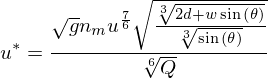

In [18]:
cm.set_friction_model('manning')
cm.u_star_eqn().simplify()

### Speed $u$

In [19]:
pdict = cm.get_params()
pdict.update({u:u,d:d})
pdict

Mean flow speed $u$ equations assuming an isoceles trapezoidal cross-section:

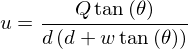

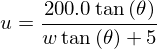

In [20]:
cm.u_eqn_geom()
_.subs(pdict).subs(d,5)

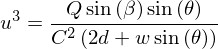

In [21]:
cm.set_friction_model('chezy')
cm.tau_eqn_dyn()
cm.u_eqn_dyn()

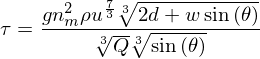

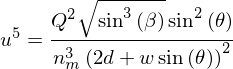

In [22]:
cm.set_friction_model('manning')
cm.tau_eqn_dyn()
u_eqn = cm.u_eqn_dyn()
u_eqn

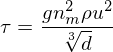

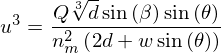

In [23]:
cm.set_friction_model('manning_depth')
cm.tau_eqn_dyn()
cm.u_eqn_dyn()

### Depth $d$

Flow depth $d$ (above centerline) equations assuming an isoceles trapezoidal cross-section:

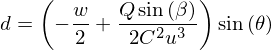

In [24]:
cm.set_friction_model('chezy')
cm.d_eqn_dyn()

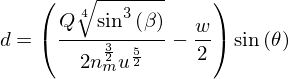

In [25]:
cm.set_friction_model('manning')
cm.d_eqn_dyn()

In [26]:
cm.set_friction_model('manning_depth')
d_eqn = Eq( (cm.u_eqn_dyn().lhs*(2*d+w*sy.sin(theta))*n_m**2)**3,
            (cm.u_eqn_dyn().rhs*(2*d+w*sy.sin(theta))*n_m**2)**3 )
d_eqn

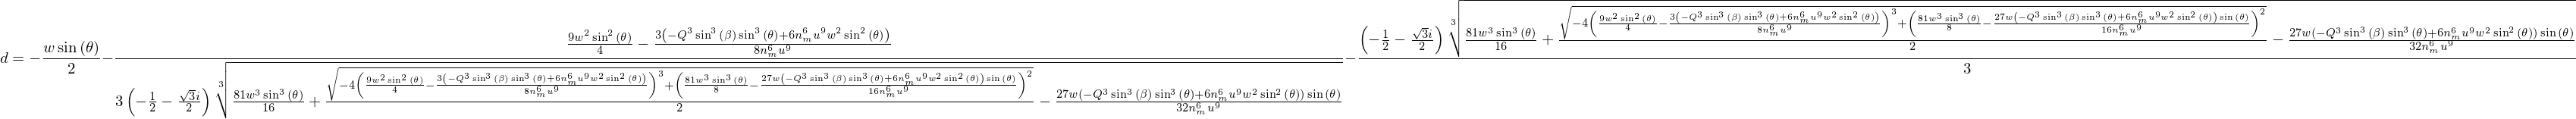

In [27]:
cm.set_friction_model('manning_depth')
d_eqn = cm.d_eqn_dyn()
d_eqn

In [28]:
sy.N(sy.re(d_eqn.rhs.subs({Q:1000,w:100,beta:0.0035,theta:sy.pi/4,n_m:0.0375})
           .subs({u:3.8})), chop=True)

### Explicit solutions for depth $d$ and speed $u$

Combining to yield polynomials for $u$ and $d$:

In [29]:
cm.set_friction_model('chezy')

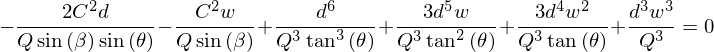

In [30]:
d_eqn = cm.d_eqn_poly()
d_eqn
_.subs({C:1,Q:1,beta:sy.pi/4,theta:sy.pi/4,w:1,n_m:1}).simplify()

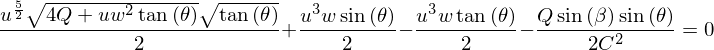

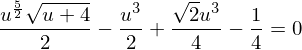

In [31]:
u_eqn = cm.u_eqn_poly()
u_eqn
u_eqn.subs({C:1,Q:1,beta:sy.pi/4,theta:sy.pi/4,w:1,n_m:1}).simplify()

In [32]:
cm.set_friction_model('manning')

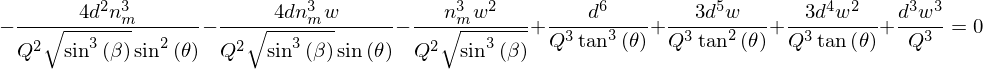

In [33]:
d_eqn = cm.d_eqn_poly()
d_eqn
_.subs({C:1,Q:1,beta:sy.pi/4,theta:sy.pi/4,w:1,n_m:1}).simplify()

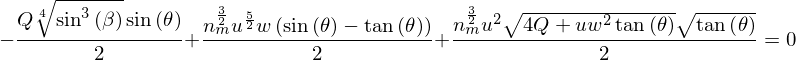

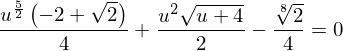

In [34]:
u_eqn = cm.u_eqn_poly()
u_eqn
u_eqn.subs({C:1,Q:1,beta:sy.pi/4,theta:sy.pi/4,w:1,n_m:1}).simplify()

By finding the positive real roots of these equations, we can obtain $d$ and then $u$ from wall tilt $\theta$, base width $w$ and channel base slope $\beta$, together with $C$ and $Q$. We can then obtain values for boundary shear stress $\tau$ and shear velocity $u^*$.

### Numerical solutions for depth $d$ and speed $u$ (Chézy) 

In [35]:
cm.reset_params()
cm.get_params()
w_x = 100
theta_x=sy.pi/4

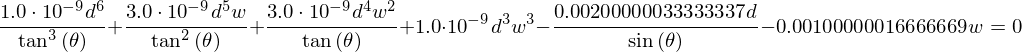

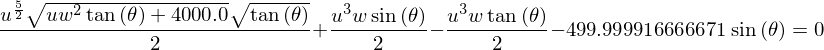

In [36]:
cm.set_friction_model('chezy')
cm.set_ud_lambdas()
cm.d_polynomial_specified
cm.u_polynomial_specified

In [37]:
u_x, d_x = cm.nsolve_u_d_for_w_theta(w_x,theta_x)
Eq(u_root,u_x)
Eq(d_root,d_x)
Eq(u-u_root,sy.N(cm.u_poly_lambda((u_x,w_x,theta_x)),chop=True))
Eq(d-d_root,sy.N(cm.d_poly_lambda((d_x,w_x,theta_x)),chop=True))

### Numerical solutions for shear velocity $u^*$, boundary shear stress $\tau$ (Chézy) 

Shear velocity $u^*$ (dimensionless) and mean boundary shear stress $\tau$ (Pa or N$\,$m$^{-1}$)

In [38]:
sy.N(cm.u_star_eqn().simplify() \
     .subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x}).subs(cm.get_params()))
sy.N(cm.tau_eqn_dyn().simplify() \
     .subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x}).subs(cm.get_params()))

### Numerical solutions for depth $d$, speed $u$ (Manning) 

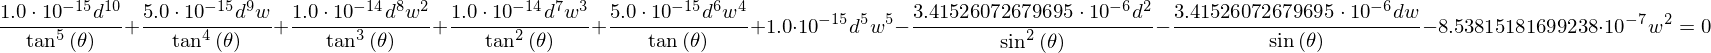

In [39]:
cm.set_friction_model('manning')
cm.set_ud_lambdas()
cm.d_polynomial_specified
cm.u_polynomial_specified

In [40]:
u_x, d_x = cm.nsolve_u_d_for_w_theta(w_x,theta_x)
Eq(u_root,u_x)
Eq(d_root,d_x)
Eq(u-u_root,sy.N(cm.u_poly_lambda((u_x,w_x,theta_x)),chop=True))
Eq(d-d_root,sy.N(cm.d_poly_lambda((d_x,w_x,theta_x)),chop=True))

### Numerical solutions for shear velocity $u^*$, boundary shear stress $\tau$  (Manning) 

Shear velocity $u^*$ (dimensionless) and mean boundary shear stress $\tau$ (Pa or N$\,$m$^{-1}$)

In [41]:
sy.N(cm.u_star_eqn().simplify() \
     .subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x}).subs(cm.get_params()))
sy.N(cm.tau_eqn_dyn().simplify() \
     .subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x}).subs(cm.get_params()))

## Sediment transport

### Bed sediment entrainment: Shields number for $\tau^*_{fine}$,  $\tau^*_{coarse}$  (Chézy)

In [42]:
cm.reset_params()
cm.get_params()
w_x = 100
theta_x=sy.pi/4

In [43]:
cm.set_friction_model('chezy')
cm.set_ud_lambdas()
u_x, d_x = cm.nsolve_u_d_for_w_theta(w_x,theta_x)

In [44]:
tau_chezy = cm.tau_eqn_dyn()
tau_chezy
tau_chezy_x = sy.N(tau_chezy.subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x})
             .subs(cm.get_params()))
tau_chezy_x

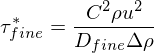

In [45]:
Eq(tau_star_fine,tau_chezy.rhs/(rho_Delta*g*D_fine))
tau_star_fine_chezy_x = sy.N(_.subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x})
                             .subs(cm.get_params()))
tau_star_fine_chezy_x
tau_star_fine_chezy_x = tau_star_fine_chezy_x.rhs

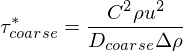

In [46]:
Eq(tau_star_coarse,tau_chezy.rhs/(rho_Delta*g*D_coarse))
tau_star_coarse_chezy_x = sy.N(_.subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x})
                               .subs(cm.get_params()))
tau_star_coarse_chezy_x
tau_star_coarse_chezy_x = tau_star_coarse_chezy_x.rhs

### Bed sediment entrainment: Shields number for $\tau^*_{fine}$, $\tau^*_{coarse}$  (Manning) 

In [47]:
cm.set_friction_model('manning')
cm.set_ud_lambdas()
u_x, d_x = cm.nsolve_u_d_for_w_theta(w_x,theta_x)

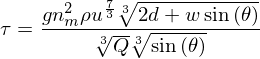

In [48]:
tau_manning = cm.tau_eqn_dyn()
tau_manning
tau_manning_x = sy.N(tau_manning.subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x})
             .subs(cm.get_params()))
tau_manning_x

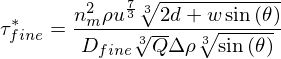

In [49]:
Eq(tau_star_fine,tau_manning.rhs/(rho_Delta*g*D_fine))
tau_star_fine_manning_x = sy.N(_.subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x})
                               .subs(cm.get_params()))
tau_star_fine_manning_x
tau_star_fine_manning_x = tau_star_fine_manning_x.rhs

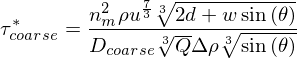

In [50]:
Eq(tau_star_coarse,tau_manning.rhs/(rho_Delta*g*D_coarse))
tau_star_coarse_manning_x = sy.N(_.subs({u:u_x,d:d_x}).subs({w:w_x,theta:theta_x})
                               .subs(cm.get_params()))
tau_star_coarse_manning_x
tau_star_coarse_manning_x = tau_star_coarse_manning_x.rhs

### Capacity bed sediment flux $q^*_{bc}$ (dimensionless) and $q_{bc}$

Fernandez Luque & van Beek (1976):

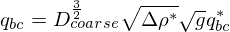

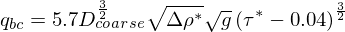

In [51]:
q_bc_eqn = Eq(q_bc, q_star_bc*(sy.sqrt(rho_star_Delta*g)*D_coarse**sy.Rational(3,2)))
q_star_bc_eqn = Eq(q_star_bc, 
                    5.7*(tau_star-tau_star_c)**sy.Rational(3,2)).subs(cm.get_params())
q_star_bc_eqn
q_bc_eqn
q_bc_eqn2 = Eq(q_bc,q_bc_eqn.rhs.subs(q_star_bc,q_star_bc_eqn.rhs))
q_bc_eqn2

### Capacity bed sediment flux $q_{bc}$    (Chézy) 

Coarse bedload (gravel) volume flux per unit channel width in units of m$^2\,$s$^{-1}$ and then in units of cm$^2\,$s$^{-1}$

In [52]:
q_bc_x = q_bc_eqn2.subs(cm.get_params()).subs(tau_star,tau_star_coarse_chezy_x)
q_bc_x
(q_bc_x.rhs*10**4).round(1)

### Capacity bed sediment flux $q_{bc}$   (Manning) 

Coarse bedload (gravel) volume flux per unit channel width in units of m$^2\,$s$^{-1}$ and then in units of cm$^2\,$s$^{-1}$

In [53]:
q_bc_x = q_bc_eqn2.subs(cm.get_params()).subs(tau_star,tau_star_coarse_manning_x)
q_bc_x
(q_bc_x.rhs*10**4).round(1)

### Suspended sediment entrainment rate $E^*$ (dimensionless)

Settling (terminal) velocity of 2mm sand in water at 10ºC

In [54]:
v_t_eqn = Eq( v_t, sy.sqrt(rho_star_Delta*g*D_fine) )
v_t_eqn
v_t_x = v_t_eqn.subs(cm.get_params())
v_t_x
(v_t_x.rhs*100).round(1)

Settling velocity per Van Rijn (1989) for $D>1\,$mm:

In [55]:
v_t_eqn = Eq( v_t, 1.1*sy.sqrt(rho_star_Delta*g*D_fine) )
v_t_eqn
v_t_x = v_t_eqn.rhs.subs(cm.get_params())
Eq(v_t,v_t_x)
(v_t_x*100).round(1)

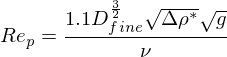

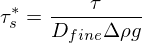

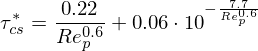

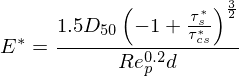

In [56]:
Re_p_eqn = Eq( Re_p, v_t_eqn.rhs*D_fine/nu )
tau_star_s_eqn = Eq( tau_star_s,tau/(rho_Delta*g*D_fine) )
tau_star_cs_eqn = Eq( tau_star_cs, 0.22*Re_p**(-0.6)+0.06*10**(-7.7*Re_p**(-0.6)) )
E_star_eqn = Eq( E_star, 
                ((0.015*D_50)/(0.01*d))
                *(tau_star_s/tau_star_cs-1)**sy.Rational(3,2)
                *Re_p**(-0.2) )
Re_p_eqn
tau_star_s_eqn
tau_star_cs_eqn
E_star_eqn
F_eqn = Eq(F,E_star*v_t)
F_eqn

### Suspended sediment entrainment rate $E^*$ and bed flux $F$ (Chézy)

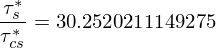

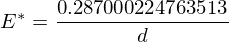

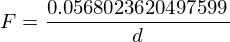

In [57]:
tau_x = tau_chezy_x
Re_p_x = Re_p_eqn.subs({}).subs(cm.get_params())
Re_p_x
tau_star_s_x = tau_star_s_eqn.rhs.subs(cm.get_params()).subs({d:d_x,tau:tau_x.rhs})
tau_star_cs_x = tau_star_cs_eqn.rhs.subs(cm.get_params()).subs(Re_p,Re_p_x.rhs)
Eq(tau_star_s,tau_star_s_x)
Eq(tau_star_cs,tau_star_cs_x)
Eq(tau_star_s/tau_star_cs, tau_star_s_x/tau_star_cs_x)
E_star_eqn_x = E_star_eqn.subs(tau_star_s,tau_star_s_x) \
                .subs(tau_star_cs,tau_star_cs_x) \
                .subs(cm.get_params()).subs(Re_p,Re_p_x.rhs)
E_star_eqn_x
F_star_eqn_x = F_eqn.subs(E_star,E_star_eqn_x.rhs).subs(v_t,v_t_x)
F_star_eqn_x

Dimensionless entrainment rate $E^*$ and vertical flux $F$ in cm$^2\,$s$^{-1}$

In [58]:
E_star_x = E_star_eqn_x.rhs.subs({d:d_x})
Eq(E_star,E_star_x)
F_x = F_star_eqn_x.rhs.subs({d:d_x})
Eq(F,F_x)
F_x*1e4

### Suspended sediment entrainment rate $E^*$ and bed flux $F$ (Manning)

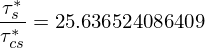

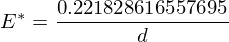

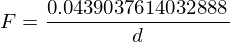

In [59]:
tau_x = tau_manning_x
Re_p_x = Re_p_eqn.subs({}).subs(cm.get_params())
Re_p_x
tau_star_s_x = tau_star_s_eqn.rhs.subs(cm.get_params()).subs({d:d_x,tau:tau_x.rhs})
tau_star_cs_x = tau_star_cs_eqn.rhs.subs(cm.get_params()).subs(Re_p,Re_p_x.rhs)
Eq(tau_star_s,tau_star_s_x)
Eq(tau_star_cs,tau_star_cs_x)
Eq(tau_star_s/tau_star_cs, tau_star_s_x/tau_star_cs_x)
E_star_eqn_x = E_star_eqn.subs(tau_star_s,tau_star_s_x) \
                .subs(tau_star_cs,tau_star_cs_x) \
                .subs(cm.get_params()).subs(Re_p,Re_p_x.rhs)
E_star_eqn_x
F_star_eqn_x = F_eqn.subs(E_star,E_star_eqn_x.rhs).subs(v_t,v_t_x)
F_star_eqn_x

Dimensionless entrainment rate $E^*$ and vertical flux $F$ in cm$^2\,$s$^{-1}$

In [60]:
E_star_x = E_star_eqn_x.rhs.subs({d:d_x})
Eq(E_star,E_star_x)
F_x = F_star_eqn_x.rhs.subs({d:d_x})
Eq(F,F_x)
F_x*1e4

### Suspended sediment flux fractions on wall $q_w$ and corner $q_c$

In [61]:
# varphi = sy.symbols('varphi',  positive=True ) 
# f_varphi = sy.Function('varphi', positive=True)(Z)
# q_ss  = sy.symbols('q_ss',  positive=True ) 
# f_q_ss = sy.Function('q_ss', positive=True)(Z)
# q_w, q_c, q_b  = sy.symbols('q_w, q_c, q_b',  positive=True ) 


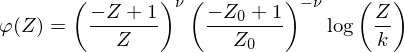

In [62]:
varphi_eqn = Eq(f_varphi, sy.log(Z/k)*((1-Z)/Z)**nu / ((1-Z_0)/Z_0)**nu)
varphi_eqn
varphi_lambda = sy.lambdify((Z,nu,k,Z_0),varphi_eqn.rhs,'sympy')

In [63]:
# sy.integrate(varphi_eqn.rhs.subs(nu,sy.Rational(3,2)),(Z,Z_0,x))

In [64]:
# sy.integrate(varphi_eqn.rhs.subs(nu,nu+1),(Z,Z_0,Z_0+x))

In [65]:
# varphi_eqn2 = sy.Eq(f_varphi, sy.log(Z/k)*((1-Z)/Z)**nu)
# varphi_eqn2.rhs.subs(nu,nu+1).subs(Z,Z+Z_0)
# sy.integrate( varphi_eqn2.rhs.subs(nu,nu+1).subs(Z,Z+Z_0) ,Z)

In [66]:
# ((Z_0/(1-Z_0))**nu)*(nu*sy.pi/sy.sin(nu*sy.pi))*(
#     -sy.log(Z_0)+sy.digamma(1-nu)+sy.digamma(2)
#     +Z_0
# )

In [67]:
# sy.simplify(qss_integral.rhs.subs(nu,2))

In [68]:
nZ = 10
dZ = 1/nZ
k_x = 0.1/30
Z_0x = 0.01
z_0x = 0.01
nu_x = 0.03/(0.4*0.2)
# nu_x = 0.06/(0.4*0.2)
varphi_lambda(Z_0x,nu_x,k_x,Z_0x)

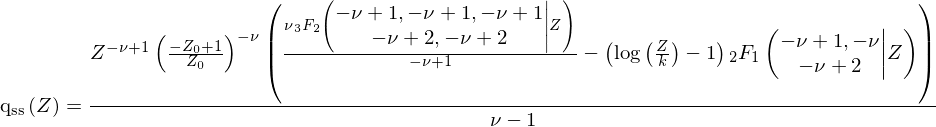

In [69]:
qss_integral = \
    Eq(f_q_ss,
            1/(nu-1) * Z**(1-nu)*(
                       nu*sy.hyper([1-nu,1-nu,1-nu],[2-nu,2-nu],Z)/(1-nu)
                    - sy.hyper([1-nu,-nu],[2-nu],Z)*(sy.log(Z/k)-1)
            )/ ((1-Z_0)/Z_0)**nu)
qss_integral
qss_lambda = sy.lambdify((Z,nu,k,Z_0),qss_integral.rhs,'sympy')

In [70]:
delta_Z_x = 0.0001
Z_x = 0.1
sy.N( 
   qss_integral.rhs.subs({Z:Z_x+delta_Z_x/2,nu:nu_x,k:k_x,Z_0:Z_0x})
  -qss_integral.rhs.subs({Z:Z_x-delta_Z_x/2,nu:nu_x,k:k_x,Z_0:Z_0x})
   )/delta_Z_x
np.float( (qss_lambda(Z_x+delta_Z_x/2,nu_x,k_x,Z_0x)
          -qss_lambda(Z_x-delta_Z_x/2,nu_x,k_x,Z_0x))/delta_Z_x )

In [71]:
def qss_portions_dimless(Z,nu,k,Z_0):
    qss_upper = sy.N(qss_lambda(1,nu,k,Z_0))
    qss_Z     = sy.N(qss_lambda(Z,nu,k,Z_0))
    qss_lower = sy.N(qss_lambda(Z_0,nu,k,Z_0))
    return np.float((qss_Z-qss_lower)/(Z-Z_0)), np.float((qss_upper-qss_lower)/(1-(Z-Z_0)))
def qss_portions(d,z,nu,k,z_0):
    return qss_portions_dimless(z/d,nu,k,z_0/d)

In [72]:
d_x = 1
qss_portions_dimless(Z_x,nu_x,k_x,Z_0x)
qss_portions(d_x,Z_x*d_x,nu_x,k_x,Z_0x*d_x)

In [73]:
q_cx, q_wx = qss_portions(d_x,Z_x*d_x,nu_x,k_x,Z_0x*d_x)
Eq(q_w, q_wx)
Eq(q_c, q_cx)

In [74]:
raise NameError('stop')

NameError: stop

## Bedrock wear

## Channel shape evolution

### Wall geometry evolution

The base-corner vector magnitude is:

In [ ]:
Eq(xi_bc, sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2)) 

The angle $\alpha$ between corner-wall vector, with dip $\phi$ from vertical, and the wall normal, with dip $\phi$ from horizontal, is:

In [ ]:
Eq(alpha,theta-phi)
Eq(sy.tan(phi),(xi_c-xi_b)/(sy.sqrt(2)*xi_b))
Eq(sy.cos(phi),xi_b/sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2))

The difference between the projection of $\vec{\xi}_{bc}$ onto the wall-normal direction and the wall-normal erosion rate $\xi_w$ leads to the rate of change of wall dip $\dot{\theta}(t)$:

In [ ]:
f_dot_theta   = sy.Function('\dot{\\theta}', real=True)(t)
sy.Eq(f_dot_theta, (xi_bc*sy.cos(theta-phi)-xi_w)*(2/h))

Since we track $\xi_{bc}(t), \xi_{w}(t), \theta(t)$ and since wall height $h(t)$ will be a simple function of (equal to?) flow depth $d(t)$, we have enought to compute $\dot{\theta}(t)$ at each time step.

At steady-state, $\dot\theta=0$, thus $\xi_w=\xi_{bc}\cos(\phi-\theta_{ss})$, and thus:

In [ ]:
Eq(sy.cos(theta_ss-phi),xi_w/sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2))
Eq(theta_ss,phi-sy.acos(xi_w/sy.sqrt(xi_b**2+(xi_c-xi_b)**2/2)))

## Numerical exploration

### Parameters

In [ ]:
cm.set_params(  {chi:0} )
cm.set_params(  {theta:cm.pi/4, Omega_r:10} )
cm.set_params(  {epsilon_r:0.1} )
cm.set_params(  {u_i:5,d_i:30} )
cm.get_params()

### Channel base width and wall tilt evolution: $\{\dot{w},\dot\theta\}(t)$

In [ ]:
cm.set_params(  {Q:250,mu:0.2,eta:2} )
cm.get_params()
w_range = (0.1,300)
import numpy as np
(ode_integrations_list, t_w_chi_beta0_vecs_list, 
 w_chi_beta0_interp_as_t_list, t_w_chi_beta0_resampled_vecs_list) \
  = cm.ode_integrate_w_chi_beta0(t_span=[0.0,1500],
                                 initial_state=np.array([50,0.05,0.001]))

In [ ]:
t_w_chi_beta0_resampled_vecs_list.round(4)
np.mean(t_w_chi_beta0_resampled_vecs_list[:,3])
cm.get_params({beta_0:None, Q:None})

In [ ]:
cm.reset_params()
cm.set_params(  {Q:3000,mu:1,eta:2} )
cm.get_params()
w_range = (0.1,300)
import numpy as np
(ode_integrations_list, t_w_chi_beta0_vecs_list, 
 w_chi_beta0_interp_as_t_list, t_w_chi_beta0_resampled_vecs_list) \
  = cm.ode_integrate_w_chi_beta0(t_span=[0.0,1500],
                                 initial_state=np.array([50,0.05,0.001]))

In [ ]:
t_w_chi_beta0_resampled_vecs_list.round(4)
np.mean(t_w_chi_beta0_resampled_vecs_list[:,3])
cm.get_params({beta_0:5, Q:None})
cm.get_params()

In [ ]:
plt.plot(t_w_chi_beta0_resampled_vecs_list[:,0],
         t_w_chi_beta0_resampled_vecs_list[:,3]);